In [27]:
"""
This is a single agent actor-critic implementation.
It is specifically designed to work with the four rooms environment, but it should work with any gym environment.
"""

import sys
import torch  
import gym
# from tqdm import tqdm
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd


In [34]:
"""
An OpenAI Gym environment for the Four Rooms domain. 
This is modified with permission from Christian Diamore's work.
"""

import gym
import numpy as np
from gym import spaces
from gym.utils import seeding

# set the torch device to be GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import typing
from typing import Tuple, List, Dict, Union, Optional

rooms = [
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
]


class FourRooms(gym.Env):
    def __init__(self, grid: list = rooms, timeout=459):
        # define the four room as a 2-D array for easy state space reference and
        # visualization 0 represents an empty cell; 1 represents a wall cell

        # NOTE: the origin for a 2-D numpy array is located at top-left
        # while the origin for the FourRooms is at the bottom-left. The following
        # codes performs the re-projection by reversing the rows
        self.grid = np.array(list(reversed(grid)))

        # define the action space
        self.observation_space, self.action_space = (
            spaces.MultiDiscrete(self.grid.shape, dtype=np.int8),
            spaces.Box(low=-1, high=1, shape=(2,), dtype=int),
        )

        # define the start and goal state
        self.agent_state = (0, 0)
        self.start_state = (0, 0)
        self.goal_state = (10, 10)

        self.t = 0
        self.timeout = timeout

    def reset(self):
        """
        Reset the agent's state to the start state [0, 0]
        Return both the start state and reward
        """
        # reset the agent state to be [0, 0]
        self.agent_state, self.t = self.start_state, 0
        return np.array(self.agent_state), {}

    def is_wall(self, state: tuple):
        return (
            not self.observation_space.contains(np.array(state))
            or self.grid[state] == 1
        )

    def step(self, act: tuple):
        """
        :param act:
            a tuple in {[1, 0], [-1, 0], [0, 1], [0, -1]} representing an
            update to the state space

        :returns:
            :next_state: tuple
                x, y integer coordinates of the agent's new state, i.e. (1, 1)
            :reward: int
                1 if the agent reached the goal, else 0
            :done: bool.
                whether the episode is done, either by hitting goal or timeout
                on the episode
        """
        self.t += 1

        # Compute the next state, and only update if we don't hit a wall
        next_state = tuple(np.array(self.agent_state) + np.array(act))
        if not self.is_wall(next_state): self.agent_state = next_state

        # Reward the agent if it hits the goal
        # Done if it was rewarded, or if it times out the episode
        reward = 0.0 if self.agent_state == (10, 10) else -1.0
        done = reward == 0.0 or (self.t >= self.timeout)

        return np.array(self.agent_state), reward, done, False, {}

    def render(self, mode="human"):
        pass


class FourRoomsController(gym.ActionWrapper):
    """Map from a discrete action space into an actual movement in the grid."""

    def __init__(self, environment: gym.Env, controls: dict[int, tuple]):
        assert all(
            environment.action_space.contains(move)
            for move in controls.values()
        )

        super().__init__(environment)
        self.controls = controls
        self.action_space = spaces.Discrete(len(controls))

    def action(self, action):
        return self.controls[action]

    def reverse_action(self, action):
        return -1 * self.controls[action]


class FourRoomsRandomJitter(gym.ActionWrapper):
    """
    With probability p, the agent takes the correct direction.
    With probability 1 - p, the agent takes one of the two perpendicular actions.

    For example, if the correct action is "LEFT", then
        - With probability 0.8, the agent takes action "LEFT";
        - With probability 0.1, the agent takes action "UP";
        - With probability 0.1, the agent takes action "DOWN".
    """
    def __init__(self, environment: gym.Env, p: float = 0.8):
        super().__init__(environment)
        self.p = p

    @staticmethod
    def perpendicular_action(action):
        return np.random.choice([2, 3] if action in [0, 1] else [0, 1], 1)[0]

    def action(self, action):
        return (
            action
            if np.random.uniform() < self.p else
            self.perpendicular_action(action)
        )

    def reverse_action(self, action):
        pass

controls={
    0: (-1, 0),  # 'LEFT'
    1: (1, 0),  # 'RIGHT'
    2: (0, -1),  # 'DOWN'
    3: (0, 1),  # 'UP'
}

timeout = 500
four_rooms_env_no_jitter = FourRoomsController(FourRooms(rooms, timeout=timeout), controls=controls)

four_rooms_env_jitter = FourRoomsRandomJitter(
    FourRoomsController(FourRooms(rooms, timeout=timeout), controls=controls), p=0.8
)


In [35]:
class ActorCriticSingleAgent(nn.Module):
    """
    A simple, but flexible, implementation of the actor-critic algorithm.
    """
    def __init__(self, num_inputs, num_actions, hidden_size, lr=3e-4):
        super(ActorCriticSingleAgent, self).__init__()

        self.num_actions = num_actions
        # estimate the value function
        self.critic1 = nn.Linear(num_inputs, hidden_size)
        self.critic2 = nn.Linear(hidden_size, 1)

        # estimate the policy distribution
        self.actor1 = nn.Linear(num_inputs, hidden_size)
        self.actor2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        """
        Do inference to calculate the action probabilities and the state value.
        """
        critic_out = F.relu(self.critic1(state))
        critic_out = self.critic2(critic_out)
        
        actor_out = F.relu(self.actor1(state))
        # softmax effectively generates a probability for each of our output options
        actor_out = F.softmax(self.actor2(actor_out), dim=0)

        return critic_out, actor_out

In [36]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [46]:
class A2CTD0:
    def __init__(self, env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma) -> None:
        self.env = env
        self.obs_size = obs_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_episodes = num_episodes
        self.num_steps = num_steps
        self.gamma = gamma

        self.model = ActorCriticSingleAgent(self.obs_size * self.env.observation_space.shape[0] + 1, self.output_size, self.hidden_size, self.learning_rate)
    
    def _get_action(self, actor_act_pred):
        # Sample an action according the probs the network just output.
        action = np.random.choice(self.output_size, p=np.squeeze(actor_act_pred))
        return action

    def _obs_to_tensor(self, obs):
        state_tensor = torch.flatten(F.one_hot(torch.tensor(obs, dtype=torch.int64), num_classes=self.obs_size))
        # add a bias bit with a value of 1 in front of the one hot vector
        state_tensor = torch.cat((torch.tensor([1.0]), state_tensor))
        return state_tensor

    def _show_episode_results(self, episode, steps, state, all_losses, average_lengths):
        if episode % 10 == 0:
            # make an array of the value of each state currently
            # make an empty array for the values of each state of shape 10x10
            state_values = np.zeros((10, 10))
            for i in range(1, 11):
                for j in range(1, 11):
                    state_tensor = self._obs_to_tensor([i, j])
                    value, _ = self.model.forward(state_tensor.float())
                    state_values[i-1][j-1] = value.detach().numpy()
            # show the value of each state with matplot lib
            plt.imshow(state_values)
            plt.show()
                # sys.stdout.write("\nState: " + str(i) + " Value: " + str(state_values))
            sys.stdout.write("\nLoss: " + str(all_losses[-1]) + "\nCurrent State: " + str(state))
            # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
            sys.stdout.write("\nepisode: {}, total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            rewards = []
            done = False
            i = 1

            state, _ = self.env.reset()
            steps = 0
            # enable n step actor critic. 
            while not done:
                state_tensor = self._obs_to_tensor(state)
                critic_td_error, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_action(detached_act_pred)

                # Calculate the log probability of the action we've taken
                log_prob = torch.distributions.Categorical(actor_act_pred).log_prob(torch.tensor(action))

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                new_state, reward, done, _, _ = self.env.step(action)
                steps += 1

                state = new_state
                
                state_tensor = self._obs_to_tensor(state)
                if not done:
                  q_val_tensor, _ = self.model.forward(state_tensor.float())
                else:
                    q_val_tensor = torch.tensor(0)
                    all_lengths.append(steps)
                    average_lengths.append(np.mean(all_lengths[-10:]))
                td_error = reward + self.gamma * q_val_tensor - critic_td_error
        
                # update actor critic
                actor_loss = -log_prob * (reward + self.gamma * q_val_tensor.item() - critic_td_error.item())
                actor_loss *= i
                critic_loss = 0.5 * td_error ** 2
                critic_loss *= i

                ac_loss = actor_loss + critic_loss + 0.001 * entropy

                ac_optimizer.zero_grad()
                ac_loss.backward()
                ac_optimizer.step()
                # all_entropies.append(entropy)
                all_losses.append(ac_loss.detach().numpy())
                i *= self.gamma
            if done:
              episode_rewards.append(np.sum(rewards))
            self._show_episode_results(episode, steps, state, all_losses, average_lengths)
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [23]:
"""
These results are generated with a2c reward of 1 on episode completion and -0.5 on every step
"""
hidden_size = 64
learning_rate = 3e-4

# Constants
gamma = 0.99
num_steps = 1
max_episodes = 1000
state_height = 11

# 22 inputs. 11 for the current state and 11 for the next state. To one hot encode our integer values.
output_size = four_rooms_env_no_jitter.action_space.n
many_run_lengths, many_run_average_lengths, many_run_entropies, many_run_losses, many_run_rewards = [], [], [], [], []

for i in range(5):
    agent = A2CTD0(four_rooms_env_no_jitter, state_height, hidden_size, output_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)
    all_lengths, average_lengths, all_entropies, all_losses, episode_rewards = agent.train()

    many_run_average_lengths.append(average_lengths)

    # rolling_avg_entropies = pd.Series(all_entropies).rolling(10).mean()
    # many_run_entropies.append(rolling_avg_entropies)
    
    rolling_avg_losses = pd.Series(all_losses).rolling(10).mean()
    many_run_losses.append(rolling_avg_losses)

    many_run_rewards.append(episode_rewards)

KeyboardInterrupt: 

In [ ]:
# plot_curves(np.array(many_run_lengths), ["A2C"], ["blue"], "Episode Length", "A2C Episode Length")
plot_curves([np.array(many_run_average_lengths)], ["A2C"], ["blue"], "Average Episode Length", "A2C Average Episode Length")
plot_curves([np.array(many_run_entropies)], ["A2C"], ["blue"], "Entropy", "A2C Entropy")
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Loss", "A2C Loss")

In [ ]:
class SAC(A2CTD0):
    def __init__(self, env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma) -> None:
        super().__init__(env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma)

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            rewards = []
            done = False
            i = 1

            state, _ = self.env.reset()
            steps = 0
            while not done:
                state_tensor = self._obs_to_tensor(state)
                critic_td_error, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_action(detached_act_pred)

                # Calculate the log probability of the action we've taken
                log_prob = torch.distributions.Categorical(actor_act_pred).log_prob(torch.tensor(action))

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                new_state, reward, done, _, _ = self.env.step(action)
                steps += 1

                state = new_state
                
                state_tensor = self._obs_to_tensor(state)
                if not done:
                  q_val_tensor, _ = self.model.forward(state_tensor.float())
                else:
                    q_val_tensor = torch.tensor(0)
                    all_lengths.append(steps)
                    average_lengths.append(np.mean(all_lengths[-10:]))
                td_error = reward + self.gamma * q_val_tensor - critic_td_error
        
                # update actor critic
                actor_loss = -log_prob * (reward + self.gamma * q_val_tensor.item() - critic_td_error.item())
                actor_loss *= i
                critic_loss = 0.5 * td_error ** 2
                critic_loss *= i

                ac_loss = actor_loss + critic_loss + 0.001 * entropy

                ac_optimizer.zero_grad()
                ac_loss.backward()
                ac_optimizer.step()
                # all_entropies.append(entropy)
                all_losses.append(ac_loss.detach().numpy())
                i *= self.gamma
            if done:
              episode_rewards.append(np.sum(rewards))
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [ ]:
"""
These results are generated with a2c reward of 1 on episode completion and -0.5 on every step
"""
hidden_size = 64
learning_rate = 3e-4

# Constants
gamma = 0.99
num_steps = 1
max_episodes = 1000
state_height = 11

# 22 inputs. 11 for the current state and 11 for the next state. To one hot encode our integer values.
output_size = four_rooms_env_no_jitter.action_space.n
many_run_lengths, many_run_average_lengths, many_run_entropies, many_run_losses, many_run_rewards = [], [], [], [], []

for i in range(5):
    agent = SAC(four_rooms_env_no_jitter, state_height, hidden_size, output_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)
    all_lengths, average_lengths, all_entropies, all_losses, episode_rewards = agent.train()

    many_run_average_lengths.append(average_lengths)

    # rolling_avg_entropies = pd.Series(all_entropies).rolling(10).mean()
    # many_run_entropies.append(rolling_avg_entropies)
    
    rolling_avg_losses = pd.Series(all_losses).rolling(10).mean()
    many_run_losses.append(rolling_avg_losses)

    many_run_rewards.append(episode_rewards)


Loss: [0.00135002]
Current State: [5 9]
episode: 0, total length: 1000, average length of prev 10: 1000.0 

Loss: [0.0016259]
Current State: [10 10]
episode: 2, total length: 702, average length of prev 10: 771.3333333333334 

Loss: [0.00147558]
Current State: [10 10]
episode: 4, total length: 912, average length of prev 10: 845.2 

Loss: [0.00139765]
Current State: [1 9]
episode: 6, total length: 1000, average length of prev 10: 889.4285714285714 

Loss: [0.00143008]
Current State: [7 0]
episode: 8, total length: 1000, average length of prev 10: 914.0 

Loss: [0.0014584]
Current State: [1 7]
episode: 10, total length: 1000, average length of prev 10: 922.6 

Loss: [0.00163831]
Current State: [1 0]
episode: 12, total length: 1000, average length of prev 10: 991.2 

Loss: [0.00176119]
Current State: [3 0]
episode: 14, total length: 1000, average length of prev 10: 1000.0 

Loss: [0.00194415]
Current State: [0 0]
episode: 16, total length: 1000, average length of prev 10: 1000.0 

Loss:

KeyboardInterrupt: 

In [47]:
class ACEligibility(A2CTD0):

    def __init__(self, env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma, lambda_) -> None:
        super().__init__(env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma)
        self.lambda_ = lambda_
        # self.model = ActorCriticSingleAgent(obs_size, hidden_size, output_size)
    
    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        all_losses = []
        average_lengths = []
        episode_rewards = []
        for episode in range(self.num_episodes):
            state, _ = self.env.reset()
            done = False
            i = 1
            z_critics = torch.zeros(1, 1)
            z_actors = torch.zeros(1, 1)
            steps = 0
            while not done:
                state_tensor = self._obs_to_tensor(state)
                critic_current_value, actor_act_pred = self.model.forward(state_tensor.float())
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_action(detached_act_pred)
                new_state, reward, done, _, _ = self.env.step(action)
                if not done:
                    new_state_tensor = self._obs_to_tensor(new_state)
                    next_state_critic, _ = self.model.forward(new_state_tensor.float())
                else:
                    all_lengths.append(steps)
                    average_lengths.append(np.mean(all_lengths[-10:]))
                    next_state_critic = torch.tensor(0)

                z_critic = self.lambda_ * self.gamma * z_critics.detach() + critic_current_value
                z_actors = self.lambda_ * self.gamma * z_actors.detach() + i * -torch.distributions.Categorical(actor_act_pred).log_prob(torch.tensor(action))
                td_error = reward + self.gamma * next_state_critic - critic_current_value

                td_error_no_grad = td_error.detach()

                actor_loss = td_error_no_grad * z_actors
                critic_loss = -z_critic * td_error
                i = self.gamma * i
                steps += 1
                state = new_state
                ac_loss = actor_loss + critic_loss
                ac_optimizer.zero_grad()
                ac_loss.backward()
                ac_optimizer.step()
                all_losses.append(ac_loss.detach().numpy())

                if done:
                    self._show_episode_results(episode, steps, state, all_losses, average_lengths)
                    
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards



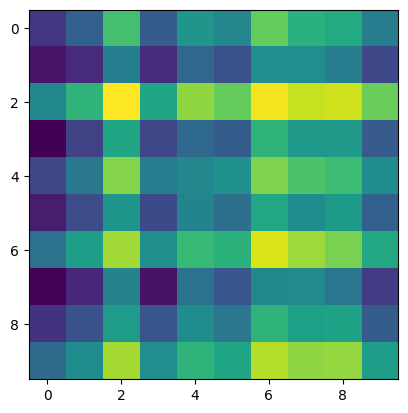


Loss: [[3.530126]]
Current State: [10 10]
episode: 0, total length: 246, average length of prev 10: 245.0 


In [48]:
"""
These results are generated with a2c reward of 1 on episode completion and -0.5 on every step
"""
hidden_size = 64
learning_rate = 3e-4

# Constants
gamma = 0.99
num_steps = 1
max_episodes = 1000
state_height = 11

# 22 inputs. 11 for the current state and 11 for the next state. To one hot encode our integer values.
output_size = four_rooms_env_no_jitter.action_space.n
many_run_lengths, many_run_average_lengths, many_run_entropies, many_run_losses, many_run_rewards = [], [], [], [], []

for i in range(5):
    agent = ACEligibility(four_rooms_env_no_jitter, state_height, hidden_size, output_size, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma, lambda_=0.9)
    all_lengths, average_lengths, all_entropies, all_losses, episode_rewards = agent.train()

    many_run_average_lengths.append(average_lengths)

    # rolling_avg_entropies = pd.Series(all_entropies).rolling(10).mean()
    # many_run_entropies.append(rolling_avg_entropies)
    
    rolling_avg_losses = pd.Series(all_losses).rolling(10).mean()
    many_run_losses.append(rolling_avg_losses)

    many_run_rewards.append(episode_rewards)